In [ ]:
## What it does: plots SPI values for intron categories (block flanking, internal or other intron) - Figure 5B
## Input: output csv from script 9 (SPI values) and from script 5 (exon_block_coordinates.csv)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu


In [15]:
spi = pd.read_csv('SPI_all_introns_nRNA_eif4a3_smash_SRS.csv')
# load block coordinate dataframe
blocks= pd.read_csv('exon_block_coordinates.csv')

In [16]:
# Calculate mean values for control and knockdown
spi['mean_ctrl'] = spi[['ctr1', 'ctr2', 'ctr3']].mean(axis=1)
spi['mean_kd'] = spi[['kd1', 'kd2', 'kd3']].mean(axis=1)

def categorize_introns(spi_df, blocks_df, mean_col):
    in_range_means = []
    upstream_means = []
    downstream_means = []

    for _, block in blocks_df.iterrows():
        chrom = block['chr']
        start = int(block['block_start'])
        end = int(block['block_end'])
        strand = block['strand']

        # In-block introns
        in_block = spi_df[(spi_df['chr'] == chrom) & (spi_df['start'] >= start) & (spi_df['end'] <= end)]
        in_range_means.extend(in_block[mean_col].dropna().tolist())

        # Strand-aware upstream/downstream
        if strand == '+':
            upstream = spi_df[(spi_df['chr'] == chrom) & (spi_df['end'] == start - 1)]
            downstream = spi_df[(spi_df['chr'] == chrom) & (spi_df['start'] == end + 1)]
        else:
            upstream = spi_df[(spi_df['chr'] == chrom) & (spi_df['start'] == end + 1)]
            downstream = spi_df[(spi_df['chr'] == chrom) & (spi_df['end'] == start - 1)]

        upstream_means.extend(upstream[mean_col].dropna().tolist())
        downstream_means.extend(downstream[mean_col].dropna().tolist())

    flanking_means = list(set(upstream_means + downstream_means))
    block_and_flank_set = set(in_range_means + flanking_means)
    all_other = spi_df.loc[~spi_df[mean_col].isin(block_and_flank_set), mean_col].dropna().tolist()

    return {
        'block intron': in_range_means,
        'flanking intron': flanking_means,
        'all other introns': all_other
    }


In [17]:
def plot_histogram(data_dict, title, outfile_prefix, xlim=(0, 1), ylim=(0, 4)):
    colors = {
        'block intron': '#F9A620',
        'flanking intron': '#104911',
        'all other introns': 'gray'
    }

    plt.figure(figsize=(6, 6))
    for category, values in data_dict.items():
        sns.histplot(
            values,
            label=category,
            kde=True,
            bins=30,
            alpha=0.3,
            stat="density",
            edgecolor=None,
            color=colors.get(category, 'blue')
        )
    plt.xlabel('Mean SPI')
    plt.ylabel('Normalized Frequency')
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.title(title)
    plt.legend(title='Intron Category')
    plt.tight_layout()
    plt.savefig(f'{outfile_prefix}.pdf')
    plt.savefig(f'{outfile_prefix}.png')
    plt.show()


In [18]:
def get_asterisks(pval):
    if pval <= 0.0001:
        return '****'
    elif pval <= 0.001:
        return '***'
    elif pval <= 0.01:
        return '**'
    elif pval <= 0.05:
        return '*'
    else:
        return 'ns'

def plot_boxplot_with_stats(data_dict, title, outfile_prefix):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Create long-form DataFrame
    df = pd.DataFrame([
        {'Mean_SPI': val, 'Category': cat}
        for cat, values in data_dict.items()
        for val in values
    ])

    # Define colors
    box_colors = {
        'block intron': '#F9A620',
        'flanking intron': '#104911',
        'all other introns': 'gray'
    }

    # Boxplot only
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(
        data=df,
        x='Category',
        y='Mean_SPI',
        palette=box_colors,
        width=0.6,
        fliersize=3,
        linewidth=1.2
    )
    ax.set_xlabel('Intron Category')
    ax.set_ylabel('Mean SPI')
    ax.set_title(title)

    # Compute pairwise comparisons
    comparisons = [
        ('block intron', 'flanking intron'),
        ('block intron', 'all other introns'),
        ('flanking intron', 'all other introns')
    ]
    y_max = df['Mean_SPI'].max()
    h = 0.05  # height between brackets
    y_pos = y_max + 0.02
    for i, (cat1, cat2) in enumerate(comparisons):
        vals1 = df[df['Category'] == cat1]['Mean_SPI']
        vals2 = df[df['Category'] == cat2]['Mean_SPI']
        stat, pval = mannwhitneyu(vals1, vals2, alternative='two-sided')
        asterisk = get_asterisks(pval)

        # Plot line and annotation
        x1, x2 = [list(data_dict.keys()).index(cat1), list(data_dict.keys()).index(cat2)]
        ax.plot([x1, x1, x2, x2], [y_pos, y_pos+h, y_pos+h, y_pos], lw=1.2, c='black')
        ax.text((x1 + x2) / 2, y_pos + h + 0.01, asterisk, ha='center', va='bottom', fontsize=12)
        y_pos += 0.07  # space out subsequent annotations

    plt.xticks(rotation=0)
    sns.despine(trim=True)
    plt.tight_layout(pad=2.0)
    plt.savefig(f'{outfile_prefix}_boxplot_stats.pdf')
    plt.savefig(f'{outfile_prefix}_boxplot_stats.png')
    plt.show()


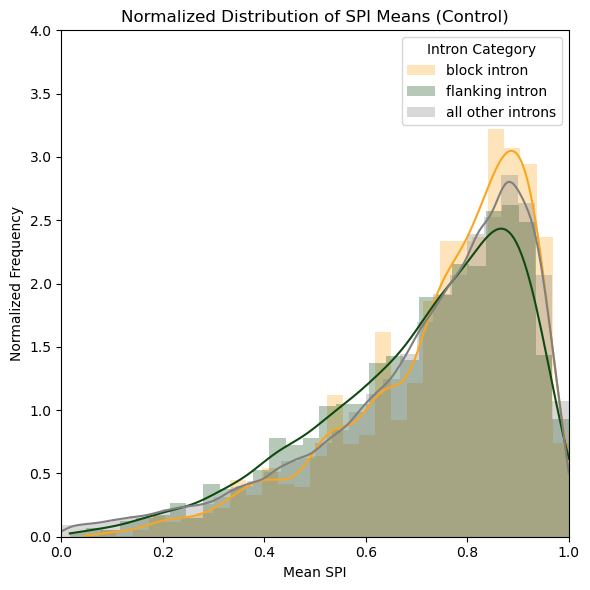

/var/folders/s5/012b_sqx2bl9vk20cyklfj_r0000gn/T/ipykernel_70283/2673136343.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


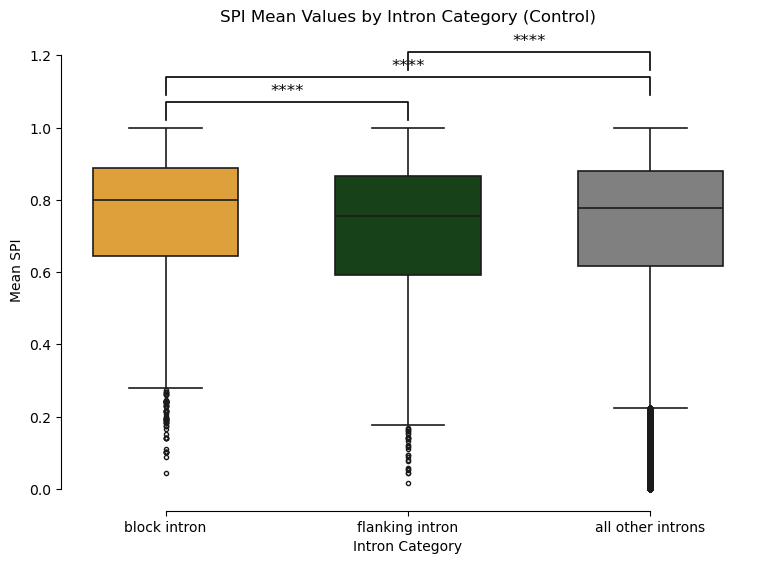

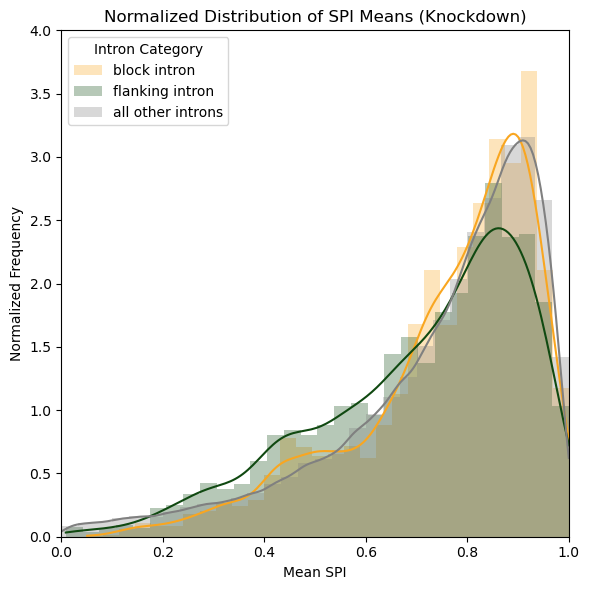

/var/folders/s5/012b_sqx2bl9vk20cyklfj_r0000gn/T/ipykernel_70283/2673136343.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


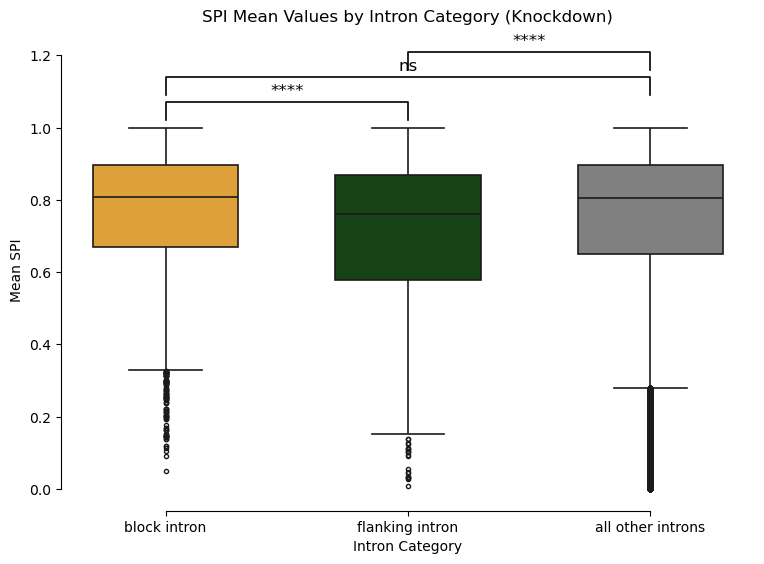

In [20]:
# --- Run for Control ---
ctrl_data = categorize_introns(spi, blocks, mean_col='mean_ctrl')
plot_histogram(ctrl_data, 'Normalized Distribution of SPI Means (Control)', 'ctr_SPI_histogram_normalized_comparison')
plot_boxplot_with_stats(ctrl_data, 'SPI Mean Values by Intron Category (Control)', 'ctr_SPI_box_plot')

# --- Run for Knockdown ---
kd_data = categorize_introns(spi, blocks, mean_col='mean_kd')
plot_histogram(kd_data, 'Normalized Distribution of SPI Means (Knockdown)', 'kd_SPI_histogram_normalized_comparison')
plot_boxplot_with_stats(kd_data, 'SPI Mean Values by Intron Category (Knockdown)', 'kd_SPI_box_plot')
